In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda")

In [4]:
from utils.model import LaplaceBayesianCNNSingleFC

In [5]:
def fixed_load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [6]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    #with open('datasplit/split_indices.pkl', 'rb') as f:
    #    split = pickle.load(f)
    #    train_dataset = Subset(dataset, split['train'])
    #    test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [7]:
num_classes = 10
bayesian_model = LaplaceBayesianCNNSingleFC(num_classes=num_classes, device=device)

In [8]:
from pyro.infer.autoguide import AutoDiagonalNormal
#from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import Adam

In [9]:
guide = AutoDiagonalNormal(bayesian_model)
#guide = AutoLowRankMultivariateNormal(bayesian_model, rank=10)

# 2. Optimizer and SVI - increase learning rate for better convergence
optimizer = Adam({"lr": 1e-3})  # Increased from 1e-4 to 1e-3
svi = pyro.infer.SVI(model=bayesian_model,
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

In [10]:
from tqdm import tqdm

In [11]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")

In [12]:
def train_svi(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    #guide.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [13]:
def train_svi_with_annealing(model, guide, svi, train_loader, num_epochs=10):
    pyro.clear_param_store()
    model.train()
    model.to(device)
    
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        # KL annealing - gradually increase KL weight
        kl_weight = min(1.0, (epoch + 1) / (num_epochs * 0.5))  # Reach full weight at 50% of training
        
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Use weighted ELBO
            def weighted_model(images, labels):
                with pyro.poutine.scale(scale=kl_weight):
                    return model(images, labels)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)

        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [14]:
"""
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)
losses, accuracies, accuracy_epochs = train_svi(bayesian_model, guide, svi, train_loader, num_epochs=100)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
"""

"\npyro.clear_param_store()\n\n# Ensure model and guide are on the correct device\nbayesian_model.to(device)\nguide.to(device)\n\ntrain_loader, test_loader = load_data(batch_size=54)\nlosses, accuracies, accuracy_epochs = train_svi(bayesian_model, guide, svi, train_loader, num_epochs=100)\n\n# Plot training curves\nplt.figure(figsize=(12, 4))\n\nplt.subplot(1, 2, 1)\nplt.plot(range(1, len(losses) + 1), losses)\nplt.title('Training Loss')\nplt.xlabel('Epoch')\nplt.ylabel('ELBO Loss')\nplt.grid(True)\n\nplt.subplot(1, 2, 2)\nplt.plot(accuracy_epochs, accuracies, 'o-')\nplt.title('Training Accuracy (Every 10 Epochs)')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.grid(True)\n\nplt.tight_layout()\nplt.show()\n"

In [15]:
def train_svi_with_stats(model, guide, svi, train_loader, num_epochs=10):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Lists to store weight and bias statistics
    weight_stats = {'epochs': [], 'means': [], 'stds': []}
    bias_stats = {'epochs': [], 'means': [], 'stds': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Record weight and bias statistics
            weight_means = []
            weight_stds = []
            bias_means = []
            bias_stds = []
            
            for name, param in pyro.get_param_store().items():
                if 'AutoDiagonalNormal.loc' in name:
                    weight_means.append(param.mean().item())
                    weight_stds.append(param.std().item())
                elif 'AutoDiagonalNormal.scale' in name:
                    bias_means.append(param.mean().item())
                    bias_stds.append(param.std().item())
            
            # Store statistics for this epoch
            weight_stats['epochs'].append(epoch + 1)
            weight_stats['means'].append(weight_means)
            weight_stats['stds'].append(weight_stds)
            
            bias_stats['epochs'].append(epoch + 1)
            bias_stats['means'].append(bias_means)
            bias_stats['stds'].append(bias_stds)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, weight_stats, bias_stats

def plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats):
    """Plot training results with weight and bias statistics"""
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid(True)
    
    # Plot 2: Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_epochs, accuracies, 'o-')
    plt.title('Training Accuracy (Every 10 Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    # Plot 3: Weight Statistics Boxplot
    plt.subplot(2, 2, 3)
    weight_data = []
    weight_labels = []
    
    for i, epoch in enumerate(weight_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = weight_stats['means'][i] + weight_stats['stds'][i]
        weight_data.append(epoch_data)
        weight_labels.append(f'Epoch {epoch}')
    
    if weight_data:
        bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.title('Weight Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('Weight Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Bias Statistics Boxplot
    plt.subplot(2, 2, 4)
    bias_data = []
    bias_labels = []
    
    for i, epoch in enumerate(bias_stats['epochs']):
        # Combine means and stds for this epoch
        epoch_data = bias_stats['means'][i] + bias_stats['stds'][i]
        bias_data.append(epoch_data)
        bias_labels.append(f'Epoch {epoch}')
    
    if bias_data:
        bp2 = plt.boxplot(bias_data, tick_labels=bias_labels, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('lightcoral')
    
    plt.title('Bias Statistics Distribution')
    plt.xlabel('Epoch')
    plt.ylabel('Bias Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [16]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with statistics recording
losses, accuracies, accuracy_epochs, weight_stats, bias_stats = train_svi_with_stats(
    bayesian_model, guide, svi, train_loader, num_epochs=100
)

Calculating accuracy for epoch 1: 100%|██████████| 400/400 [00:06<00:00, 58.04it/s]


Epoch 1 - ELBO Loss: 14415804.1644, Train Accuracy: 36.67%


Epoch 2/100: 100%|██████████| 400/400 [00:10<00:00, 38.25it/s]


Epoch 2 - ELBO Loss: 7411347.4841


Epoch 3/100: 100%|██████████| 400/400 [00:10<00:00, 39.44it/s]


Epoch 3 - ELBO Loss: 5624958.3753


Epoch 4/100: 100%|██████████| 400/400 [00:09<00:00, 44.37it/s]


Epoch 4 - ELBO Loss: 4563274.2327


Epoch 5/100: 100%|██████████| 400/400 [00:08<00:00, 45.18it/s]


Epoch 5 - ELBO Loss: 3902009.2466


Epoch 6/100: 100%|██████████| 400/400 [00:08<00:00, 45.06it/s]


Epoch 6 - ELBO Loss: 3402718.4604


Epoch 7/100: 100%|██████████| 400/400 [00:08<00:00, 45.29it/s]


Epoch 7 - ELBO Loss: 3021288.1027


Epoch 8/100: 100%|██████████| 400/400 [00:08<00:00, 45.23it/s]


Epoch 8 - ELBO Loss: 2726063.2517


Epoch 9/100: 100%|██████████| 400/400 [00:08<00:00, 45.12it/s]


Epoch 9 - ELBO Loss: 2512624.2877


Calculating accuracy for epoch 10: 100%|██████████| 400/400 [00:03<00:00, 121.44it/s]


Epoch 10 - ELBO Loss: 2310220.4259, Train Accuracy: 61.30%


Epoch 11/100: 100%|██████████| 400/400 [00:08<00:00, 45.17it/s]


Epoch 11 - ELBO Loss: 2142189.1716


Epoch 12/100: 100%|██████████| 400/400 [00:08<00:00, 45.15it/s]


Epoch 12 - ELBO Loss: 2001477.6579


Epoch 13/100: 100%|██████████| 400/400 [00:08<00:00, 44.94it/s]


Epoch 13 - ELBO Loss: 1854716.7173


Epoch 14/100: 100%|██████████| 400/400 [00:08<00:00, 44.45it/s]


Epoch 14 - ELBO Loss: 1732607.9195


Epoch 15/100: 100%|██████████| 400/400 [00:09<00:00, 43.61it/s]


Epoch 15 - ELBO Loss: 1635674.3003


Epoch 16/100: 100%|██████████| 400/400 [00:08<00:00, 44.60it/s]


Epoch 16 - ELBO Loss: 1549559.8667


Epoch 17/100: 100%|██████████| 400/400 [00:08<00:00, 44.84it/s]


Epoch 17 - ELBO Loss: 1475167.0574


Epoch 18/100: 100%|██████████| 400/400 [00:08<00:00, 45.03it/s]


Epoch 18 - ELBO Loss: 1401862.0008


Epoch 19/100: 100%|██████████| 400/400 [00:08<00:00, 44.54it/s]


Epoch 19 - ELBO Loss: 1326006.4294


Calculating accuracy for epoch 20: 100%|██████████| 400/400 [00:03<00:00, 120.54it/s]


Epoch 20 - ELBO Loss: 1268792.7146, Train Accuracy: 61.56%


Epoch 21/100: 100%|██████████| 400/400 [00:09<00:00, 44.21it/s]


Epoch 21 - ELBO Loss: 1210149.3175


Epoch 22/100: 100%|██████████| 400/400 [00:09<00:00, 44.41it/s]


Epoch 22 - ELBO Loss: 1158904.1693


Epoch 23/100: 100%|██████████| 400/400 [00:08<00:00, 44.53it/s]


Epoch 23 - ELBO Loss: 1111599.9838


Epoch 24/100: 100%|██████████| 400/400 [00:08<00:00, 44.94it/s]


Epoch 24 - ELBO Loss: 1070143.5106


Epoch 25/100: 100%|██████████| 400/400 [00:08<00:00, 45.23it/s]


Epoch 25 - ELBO Loss: 1030674.3417


Epoch 26/100: 100%|██████████| 400/400 [00:09<00:00, 44.39it/s]


Epoch 26 - ELBO Loss: 992119.8508


Epoch 27/100: 100%|██████████| 400/400 [00:08<00:00, 45.01it/s]


Epoch 27 - ELBO Loss: 954384.0615


Epoch 28/100: 100%|██████████| 400/400 [00:08<00:00, 45.10it/s]


Epoch 28 - ELBO Loss: 919720.2668


Epoch 29/100: 100%|██████████| 400/400 [00:08<00:00, 45.04it/s]


Epoch 29 - ELBO Loss: 880963.6510


Calculating accuracy for epoch 30: 100%|██████████| 400/400 [00:03<00:00, 120.90it/s]


Epoch 30 - ELBO Loss: 844201.9605, Train Accuracy: 45.12%


Epoch 31/100: 100%|██████████| 400/400 [00:08<00:00, 44.53it/s]


Epoch 31 - ELBO Loss: 807178.2822


Epoch 32/100: 100%|██████████| 400/400 [00:09<00:00, 44.06it/s]


Epoch 32 - ELBO Loss: 770396.5670


Epoch 33/100: 100%|██████████| 400/400 [00:09<00:00, 43.75it/s]


Epoch 33 - ELBO Loss: 732631.6742


Epoch 34/100: 100%|██████████| 400/400 [00:08<00:00, 44.49it/s]


Epoch 34 - ELBO Loss: 696331.0845


Epoch 35/100: 100%|██████████| 400/400 [00:08<00:00, 44.56it/s]


Epoch 35 - ELBO Loss: 662170.2913


Epoch 36/100: 100%|██████████| 400/400 [00:08<00:00, 44.50it/s]


Epoch 36 - ELBO Loss: 629878.1349


Epoch 37/100: 100%|██████████| 400/400 [00:08<00:00, 45.00it/s]


Epoch 37 - ELBO Loss: 599195.5225


Epoch 38/100: 100%|██████████| 400/400 [00:08<00:00, 44.56it/s]


Epoch 38 - ELBO Loss: 569197.8973


Epoch 39/100: 100%|██████████| 400/400 [00:09<00:00, 44.24it/s]


Epoch 39 - ELBO Loss: 539367.2439


Calculating accuracy for epoch 40: 100%|██████████| 400/400 [00:03<00:00, 119.64it/s]


Epoch 40 - ELBO Loss: 509796.9388, Train Accuracy: 11.57%


Epoch 41/100: 100%|██████████| 400/400 [00:09<00:00, 44.19it/s]


Epoch 41 - ELBO Loss: 480706.6390


Epoch 42/100: 100%|██████████| 400/400 [00:09<00:00, 44.18it/s]


Epoch 42 - ELBO Loss: 452275.6859


Epoch 43/100: 100%|██████████| 400/400 [00:09<00:00, 44.14it/s]


Epoch 43 - ELBO Loss: 424455.1956


Epoch 44/100: 100%|██████████| 400/400 [00:09<00:00, 44.19it/s]


Epoch 44 - ELBO Loss: 397496.6956


Epoch 45/100: 100%|██████████| 400/400 [00:09<00:00, 44.27it/s]


Epoch 45 - ELBO Loss: 371341.4651


Epoch 46/100: 100%|██████████| 400/400 [00:08<00:00, 44.63it/s]


Epoch 46 - ELBO Loss: 346218.3295


Epoch 47/100: 100%|██████████| 400/400 [00:08<00:00, 44.55it/s]


Epoch 47 - ELBO Loss: 322207.4220


Epoch 48/100: 100%|██████████| 400/400 [00:08<00:00, 44.46it/s]


Epoch 48 - ELBO Loss: 299478.9112


Epoch 49/100: 100%|██████████| 400/400 [00:09<00:00, 44.17it/s]


Epoch 49 - ELBO Loss: 278027.2635


Calculating accuracy for epoch 50: 100%|██████████| 400/400 [00:03<00:00, 102.12it/s]


Epoch 50 - ELBO Loss: 258102.4403, Train Accuracy: 10.67%


Epoch 51/100: 100%|██████████| 400/400 [00:09<00:00, 43.09it/s]


Epoch 51 - ELBO Loss: 239843.6877


Epoch 52/100: 100%|██████████| 400/400 [00:09<00:00, 43.12it/s]


Epoch 52 - ELBO Loss: 223226.6217


Epoch 53/100: 100%|██████████| 400/400 [00:08<00:00, 44.45it/s]


Epoch 53 - ELBO Loss: 208207.7890


Epoch 54/100: 100%|██████████| 400/400 [00:09<00:00, 44.09it/s]


Epoch 54 - ELBO Loss: 194811.0014


Epoch 55/100: 100%|██████████| 400/400 [00:09<00:00, 44.20it/s]


Epoch 55 - ELBO Loss: 182785.1507


Epoch 56/100: 100%|██████████| 400/400 [00:08<00:00, 44.52it/s]


Epoch 56 - ELBO Loss: 172040.9974


Epoch 57/100: 100%|██████████| 400/400 [00:09<00:00, 43.96it/s]


Epoch 57 - ELBO Loss: 162556.1957


Epoch 58/100: 100%|██████████| 400/400 [00:09<00:00, 44.23it/s]


Epoch 58 - ELBO Loss: 153945.4634


Epoch 59/100: 100%|██████████| 400/400 [00:09<00:00, 43.84it/s]


Epoch 59 - ELBO Loss: 146117.7607


Calculating accuracy for epoch 60: 100%|██████████| 400/400 [00:03<00:00, 120.22it/s]


Epoch 60 - ELBO Loss: 139368.2296, Train Accuracy: 10.24%


Epoch 61/100: 100%|██████████| 400/400 [00:09<00:00, 43.76it/s]


Epoch 61 - ELBO Loss: 132999.8700


Epoch 62/100: 100%|██████████| 400/400 [00:09<00:00, 43.68it/s]


Epoch 62 - ELBO Loss: 127417.7795


Epoch 63/100: 100%|██████████| 400/400 [00:09<00:00, 43.81it/s]


Epoch 63 - ELBO Loss: 121973.5235


Epoch 64/100: 100%|██████████| 400/400 [00:09<00:00, 44.22it/s]


Epoch 64 - ELBO Loss: 117224.0667


Epoch 65/100: 100%|██████████| 400/400 [00:09<00:00, 42.86it/s]


Epoch 65 - ELBO Loss: 112898.1009


Epoch 66/100: 100%|██████████| 400/400 [00:09<00:00, 44.08it/s]


Epoch 66 - ELBO Loss: 108816.2511


Epoch 67/100: 100%|██████████| 400/400 [00:09<00:00, 44.32it/s]


Epoch 67 - ELBO Loss: 105179.6457


Epoch 68/100: 100%|██████████| 400/400 [00:09<00:00, 44.34it/s]


Epoch 68 - ELBO Loss: 101764.9434


Epoch 69/100: 100%|██████████| 400/400 [00:09<00:00, 44.21it/s]


Epoch 69 - ELBO Loss: 98801.5671


Calculating accuracy for epoch 70: 100%|██████████| 400/400 [00:03<00:00, 119.35it/s]


Epoch 70 - ELBO Loss: 95677.9664, Train Accuracy: 10.31%


Epoch 71/100: 100%|██████████| 400/400 [00:09<00:00, 44.11it/s]


Epoch 71 - ELBO Loss: 93193.4905


Epoch 72/100: 100%|██████████| 400/400 [00:09<00:00, 43.75it/s]


Epoch 72 - ELBO Loss: 90702.9193


Epoch 73/100: 100%|██████████| 400/400 [00:09<00:00, 44.32it/s]


Epoch 73 - ELBO Loss: 88255.0058


Epoch 74/100: 100%|██████████| 400/400 [00:08<00:00, 44.56it/s]


Epoch 74 - ELBO Loss: 86258.1726


Epoch 75/100: 100%|██████████| 400/400 [00:09<00:00, 44.41it/s]


Epoch 75 - ELBO Loss: 84483.0366


Epoch 76/100: 100%|██████████| 400/400 [00:08<00:00, 44.47it/s]


Epoch 76 - ELBO Loss: 82528.6133


Epoch 77/100: 100%|██████████| 400/400 [00:09<00:00, 44.21it/s]


Epoch 77 - ELBO Loss: 81011.4088


Epoch 78/100: 100%|██████████| 400/400 [00:09<00:00, 43.41it/s]


Epoch 78 - ELBO Loss: 79362.1919


Epoch 79/100: 100%|██████████| 400/400 [00:08<00:00, 44.46it/s]


Epoch 79 - ELBO Loss: 77639.0933


Calculating accuracy for epoch 80: 100%|██████████| 400/400 [00:03<00:00, 118.53it/s]


Epoch 80 - ELBO Loss: 76797.5896, Train Accuracy: 10.61%


Epoch 81/100: 100%|██████████| 400/400 [00:08<00:00, 44.91it/s]


Epoch 81 - ELBO Loss: 75325.2622


Epoch 82/100: 100%|██████████| 400/400 [00:09<00:00, 43.98it/s]


Epoch 82 - ELBO Loss: 74346.0528


Epoch 83/100: 100%|██████████| 400/400 [00:09<00:00, 44.18it/s]


Epoch 83 - ELBO Loss: 73222.0913


Epoch 84/100: 100%|██████████| 400/400 [00:09<00:00, 44.12it/s]


Epoch 84 - ELBO Loss: 72164.9670


Epoch 85/100: 100%|██████████| 400/400 [00:08<00:00, 44.65it/s]


Epoch 85 - ELBO Loss: 71311.8080


Epoch 86/100: 100%|██████████| 400/400 [00:09<00:00, 44.37it/s]


Epoch 86 - ELBO Loss: 70940.1278


Epoch 87/100: 100%|██████████| 400/400 [00:08<00:00, 44.49it/s]


Epoch 87 - ELBO Loss: 69935.8237


Epoch 88/100: 100%|██████████| 400/400 [00:08<00:00, 44.57it/s]


Epoch 88 - ELBO Loss: 68504.4100


Epoch 89/100: 100%|██████████| 400/400 [00:09<00:00, 44.11it/s]


Epoch 89 - ELBO Loss: 68137.9959


Calculating accuracy for epoch 90: 100%|██████████| 400/400 [00:03<00:00, 119.08it/s]


Epoch 90 - ELBO Loss: 67113.9973, Train Accuracy: 10.16%


Epoch 91/100: 100%|██████████| 400/400 [00:09<00:00, 44.38it/s]


Epoch 91 - ELBO Loss: 66260.0217


Epoch 92/100: 100%|██████████| 400/400 [00:08<00:00, 44.53it/s]


Epoch 92 - ELBO Loss: 65673.8892


Epoch 93/100: 100%|██████████| 400/400 [00:09<00:00, 43.96it/s]


Epoch 93 - ELBO Loss: 65382.7899


Epoch 94/100: 100%|██████████| 400/400 [00:09<00:00, 43.77it/s]


Epoch 94 - ELBO Loss: 64540.6455


Epoch 95/100: 100%|██████████| 400/400 [00:09<00:00, 43.10it/s]


Epoch 95 - ELBO Loss: 63663.2125


Epoch 96/100: 100%|██████████| 400/400 [00:08<00:00, 44.57it/s]


Epoch 96 - ELBO Loss: 63257.9597


Epoch 97/100: 100%|██████████| 400/400 [00:09<00:00, 44.43it/s]


Epoch 97 - ELBO Loss: 62324.5632


Epoch 98/100: 100%|██████████| 400/400 [00:08<00:00, 44.81it/s]


Epoch 98 - ELBO Loss: 62430.9685


Epoch 99/100: 100%|██████████| 400/400 [00:08<00:00, 44.65it/s]


Epoch 99 - ELBO Loss: 61519.4939


Calculating accuracy for epoch 100: 100%|██████████| 400/400 [00:03<00:00, 120.22it/s]

Epoch 100 - ELBO Loss: 60912.1809, Train Accuracy: 10.56%


C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_25560\27061161.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(weight_data, labels=weight_labels, patch_artist=True)


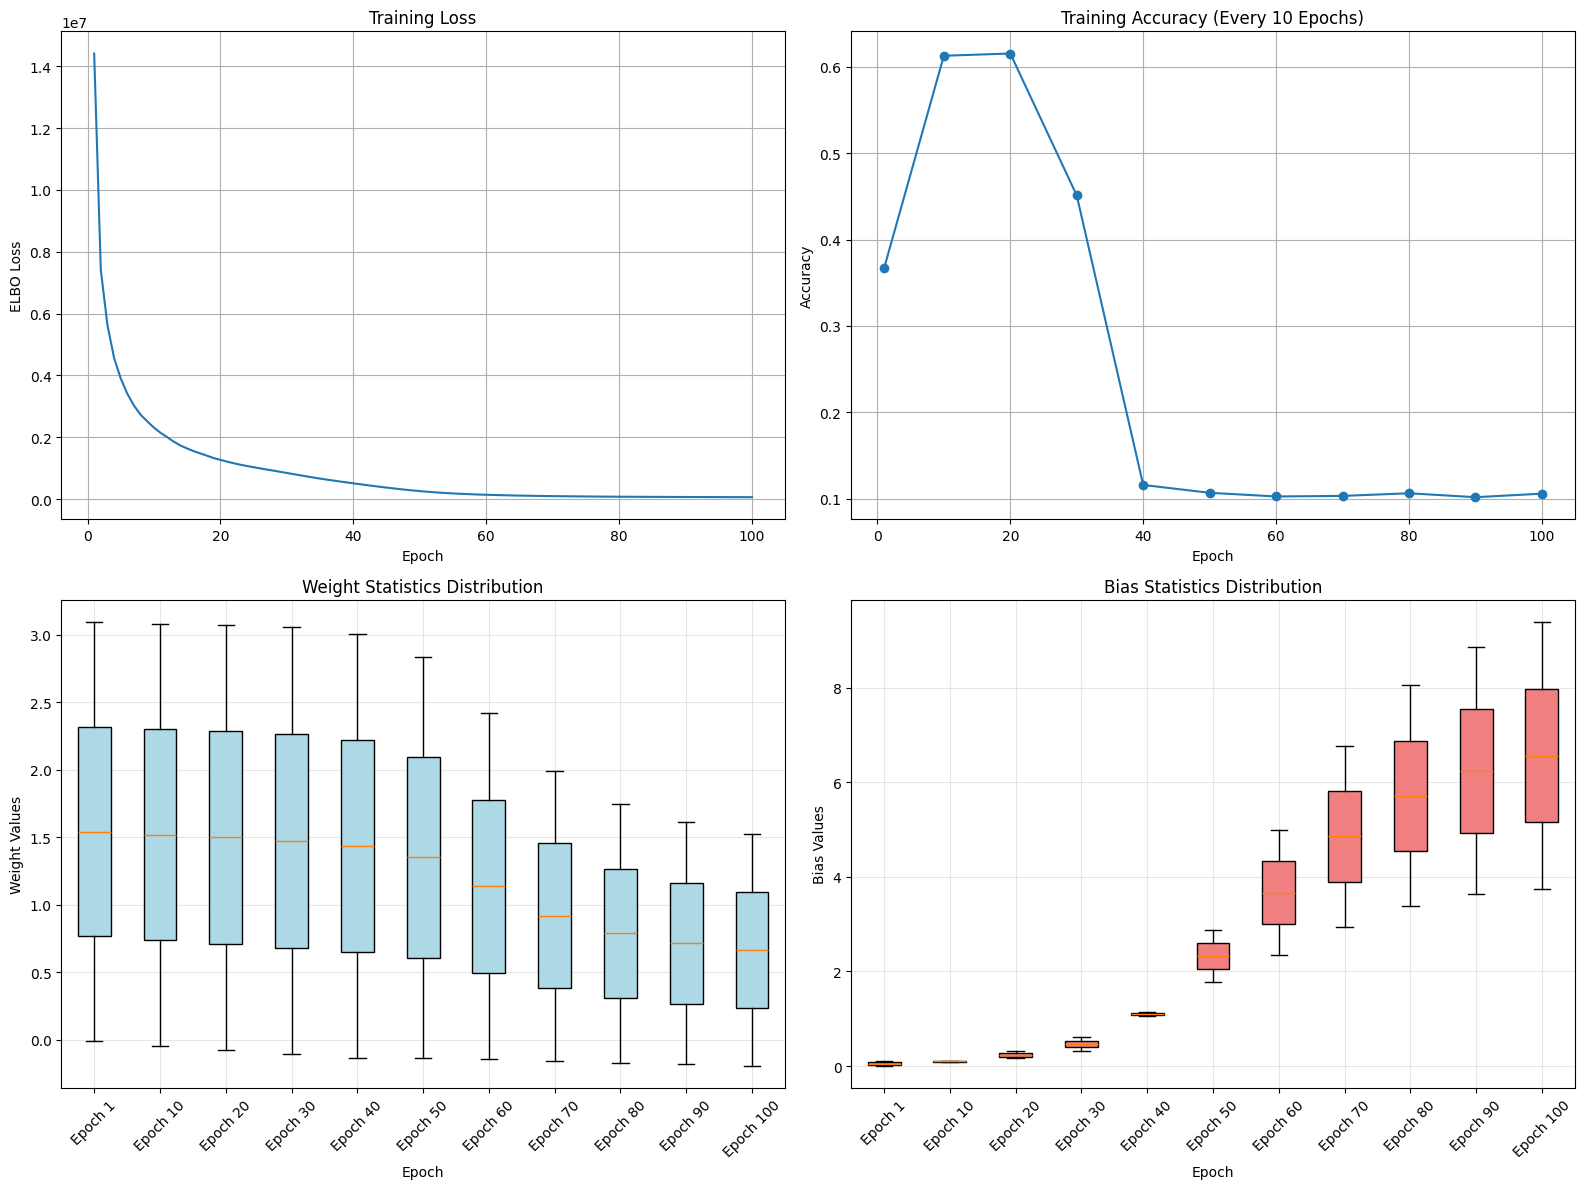

In [17]:
# Plot all results including weight and bias statistics
plot_training_results_with_stats(losses, accuracies, accuracy_epochs, weight_stats, bias_stats)

In [ ]:
weight_means = []
weight_stds = []
bias_means = []
bias_stds = []

In [ ]:
for name, param in pyro.get_param_store().items():
    print(f"Parameter: {name}, Mean: {param.mean().item()}, Std: {param.std().item()}")
    if 'AutoDiagonalNormal.loc' in name:
        weight_means.append(param.mean().item())
        weight_stds.append(param.std().item())
    elif 'AutoDiagonalNormal.scale' in name:
        bias_means.append(param.mean().item())
        bias_stds.append(param.std().item())

In [ ]:
weight_means

In [ ]:
#pyro.clear_param_store()

# Ensure model and guide are on the correct device
#bayesian_model.to(device)
#guide.to(device)

#train_loader, test_loader = load_data(batch_size=54)
#train_svi(bayesian_model, guide, svi, train_loader, num_epochs=0)

In [ ]:
# save the model
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch_laplace.pth'
torch.save(bayesian_model.state_dict(), model_path)

# save the guide
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide_laplace.pth'
torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch_laplace.pkl'
pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
import numpy as np

In [ ]:
# print confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix


def predict_data(model, loader_of_interest, num_samples=10):
    model.eval()
    guide.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader_of_interest, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            logits_mc = torch.zeros(num_samples, images.size(0), model.fc1.out_features).to(device)

            for i in range(num_samples):
                guide_trace = pyro.poutine.trace(guide).get_trace(images)
                replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                logits = replayed_model(images)
                logits_mc[i] = logits

            avg_logits = logits_mc.mean(dim=0)
            predictions = torch.argmax(avg_logits, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

In [ ]:
train_labels, train_predictions = predict_data(bayesian_model, train_loader, num_samples=10)

In [ ]:
train_cm = confusion_matrix(train_labels, train_predictions)

In [ ]:
#print accuracy from confusion matrix
train_accuracy = np.trace(train_cm) / np.sum(train_cm)
print(f"Train accuracy from confusion matrix: {train_accuracy * 100:.6f}%")

In [ ]:
all_labels, all_predictions = predict_data(bayesian_model, test_loader, num_samples=10)

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)

In [ ]:
#print accuracy from confusion matrix
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy from confusion matrix: {accuracy * 100:.6f}%")

In [ ]:
# print pyro parameters
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape} - {value.mean().item():.4f} ± {value.std().item():.4f}")

60.092593% for the 10 epoch

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    # make a mark to the diagonal
    plt.plot([0, cm.shape[1]-1], [0, cm.shape[0]-1], color='red', linestyle='--', linewidth=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
plot_confusion_matrix(cm, class_names)

In [ ]:
# save the model
#model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
#torch.save(bayesian_model.state_dict(), model_path)

# save the guide
#guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
#torch.save(guide.state_dict(), guide_path)

# save the pyro parameter store
#pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'
#pyro.get_param_store().save(pyro_param_store_path)

In [ ]:
kataguediemdeh

In [ ]:
def train_svi_early_save(model, guide, svi, train_loader, num_epochs=10, patience=3, min_delta=0.001):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    # Early stopping variables
    best_accuracy = 0.0
    best_epoch = 0
    patience_counter = 0
    best_model_state = None
    best_guide_state = None
    best_pyro_params = None
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Check for improvement
            if epoch_accuracy > best_accuracy + min_delta:
                best_accuracy = epoch_accuracy
                best_epoch = epoch + 1
                patience_counter = 0
                
                # Save best model states
                best_model_state = model.state_dict().copy()
                best_guide_state = guide.state_dict().copy()
                best_pyro_params = pyro.get_param_store().get_state().copy()
                
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% *** NEW BEST ***")
            else:
                patience_counter += 1
                print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}% (Best: {best_accuracy*100:.2f}% at epoch {best_epoch})")
                
                # Early stopping check
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} evaluations.")
                    print(f"Best accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")
                    
                    # Restore best model
                    model.load_state_dict(best_model_state)
                    guide.load_state_dict(best_guide_state)
                    pyro.get_param_store().set_state(best_pyro_params)
                    
                    break
            
            model.train()  # Set back to training mode
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # If training completed without early stopping, still restore best model
    if patience_counter < patience and best_model_state is not None:
        print(f"\nTraining completed. Restoring best model from epoch {best_epoch} (accuracy: {best_accuracy*100:.2f}%)")
        model.load_state_dict(best_model_state)
        guide.load_state_dict(best_guide_state)
        pyro.get_param_store().set_state(best_pyro_params)
    
    return epoch_losses, epoch_accuracies, accuracy_epochs, best_epoch, best_accuracy

In [ ]:
pyro.clear_param_store()

# Ensure model and guide are on the correct device
bayesian_model.to(device)
guide.to(device)

train_loader, test_loader = load_data(batch_size=54)

# Train with early stopping
losses, accuracies, accuracy_epochs, best_epoch, best_accuracy = train_svi(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100, 
    patience=3,  # Stop if no improvement for 3 accuracy evaluations (30 epochs)
    min_delta=0.001  # Minimum improvement threshold (0.1%)
)

print(f"\nFinal Results:")
print(f"Best training accuracy: {best_accuracy*100:.2f}% at epoch {best_epoch}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs, accuracies, 'o-')
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_accuracy, color='red', linestyle=':', alpha=0.7)
plt.title('Training Accuracy (Every 10 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:
def train_svi_with_tensorboard(model, guide, svi, train_loader, num_epochs=10, log_dir='runs/bayesian_cnn'):
    # Clear parameter store only ONCE at the beginning
    pyro.clear_param_store()
    model.train()
    
    # Ensure model is on the correct device
    model.to(device)
    
    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)
    
    # Lists to store losses and accuracies
    epoch_losses = []
    epoch_accuracies = []
    accuracy_epochs = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            loss = svi.step(images, labels)
            epoch_loss += loss
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        epoch_losses.append(avg_loss)
        
        # Log loss to TensorBoard every epoch
        writer.add_scalar('Loss/ELBO', avg_loss, epoch + 1)
        
        # Calculate accuracy every 10 epochs (and on the first and last epoch)
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            model.eval()
            guide.eval()
            
            correct_predictions = 0
            total_samples = 0
            
            with torch.no_grad():
                for images, labels in tqdm(train_loader, desc=f"Calculating accuracy for epoch {epoch+1}"):
                    images, labels = images.to(device), labels.to(device)
                    
                    # Sample from the guide to get model parameters
                    guide_trace = pyro.poutine.trace(guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(model, trace=guide_trace)
                    
                    # Get predictions
                    logits = replayed_model(images)
                    predictions = torch.argmax(logits, dim=1)
                    
                    # Count correct predictions
                    correct_predictions += (predictions == labels).sum().item()
                    total_samples += labels.size(0)
            
            epoch_accuracy = correct_predictions / total_samples
            epoch_accuracies.append(epoch_accuracy)
            accuracy_epochs.append(epoch + 1)
            
            # Log accuracy to TensorBoard
            writer.add_scalar('Accuracy/Train', epoch_accuracy, epoch + 1)
            
            model.train()  # Set back to training mode
            
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%")
        else:
            print(f"Epoch {epoch+1} - ELBO Loss: {avg_loss:.4f}")
    
    # Close the writer
    writer.close()
    
    return epoch_losses, epoch_accuracies, accuracy_epochs

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

In [ ]:
# Train with TensorBoard logging
losses, accuracies, accuracy_epochs = train_svi_with_tensorboard(
    bayesian_model, guide, svi, train_loader, 
    num_epochs=100,
    log_dir='runs/eurosat_bayesian_cnn_experiment'
)

Feature TODO:
1. Record loss after each epoch
2. Send result to GPU